## Perform SMOTE and Test the Results with Hyperparameter Tuning

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE



In [253]:
# read in the protein and updrs data
updrs1_df = pd.read_csv('../data/processed/train_updrs_1_cat.csv')
updrs2_df = pd.read_csv('../data/processed/train_updrs_2_cat.csv')
updrs3_df = pd.read_csv('../data/processed/train_updrs_3_cat.csv')

In [254]:
updrs1_df['updrs_1_cat'].value_counts()

mild        854
moderate    199
severe       15
Name: updrs_1_cat, dtype: int64

In [255]:
updrs2_df['updrs_2_cat'].value_counts()

mild        910
moderate    158
Name: updrs_2_cat, dtype: int64

In [256]:
updrs3_df['updrs_3_cat'].value_counts()

mild        880
moderate    168
severe       10
Name: updrs_3_cat, dtype: int64

In [257]:
# replace the categorical updrs scores with numerical for mild, moderate and severe
## combine the moderate and severe categories since there are very few severe observations
updrs1_df['updrs_1_cat'] = updrs1_df['updrs_1_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs2_df['updrs_2_cat'] = updrs2_df['updrs_2_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})
updrs3_df['updrs_3_cat'] = updrs3_df['updrs_3_cat'].map({'mild': 0, 'moderate': 1, 'severe': 1})

In [258]:
updrs3_df['updrs_3_cat'].value_counts()

0    880
1    178
Name: updrs_3_cat, dtype: int64

In [259]:
updrs3_df.columns

Index(['visit_id', 'patient_id', 'visit_month', 'updrs_3', 'O00391', 'O00533',
       'O00584', 'O14498', 'O14773', 'O14791',
       ...
       'YVNKEIQNAVNGVK_P10909', 'YWGVASFLQK_P02753',
       'YYC(UniMod_4)FQGNQFLR_P02790', 'YYTYLIMNK_P01024',
       'YYWGGQYTWDMAK_P02675', 'kfold', 'num_prot_pep', 'num_prot', 'num_pept',
       'updrs_3_cat'],
      dtype='object', length=1204)

In [260]:
## create smote function
def smote_data(df, target):
    """
    Function to perform SMOTE on a dataframe with a target variable
    """
    # separate the target variable from the dataframe
    X = df.drop(columns=target)
    y = df[target]
    
    # perform smote on the data
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)
    
    # create a dataframe from the smote data
    X_smote_df = pd.DataFrame(X_smote, columns=X.columns)
    y_smote_df = pd.DataFrame(y_smote, columns=[target])
    
    # combine the X and y smote dataframes
    smote_df = pd.concat([X_smote_df, y_smote_df], axis=1)
    
    return smote_df

In [261]:
updrs1_df_smote = smote_data(updrs1_df[updrs1_df['kfold']!=0], 'updrs_1_cat')

In [262]:
updrs1_test_df = updrs1_df[updrs1_df['kfold']==0]

In [263]:
updrs1_df_smote['updrs_1_cat'].value_counts()

1    683
0    683
Name: updrs_1_cat, dtype: int64

In [264]:

def cross_fold_validation(df, model, target):

    updrs_results = dict()
    
    for fold in range(1, 5):
        # get the train and test data for the current fold
        train = df[df['kfold'] != fold].reset_index(drop=True)
        test = df[df['kfold'] == fold].reset_index(drop=True)

        # get the train and test data for the current fold
        drop_cols = ['visit_id', 'patient_id', f'{target}', 'kfold', f'{target}_cat']
        X_train = train.drop(columns=drop_cols)
        y_train = train[f'{target}_cat']
        X_test = test.drop(columns=drop_cols)
        y_test = test[f'{target}_cat']

        # train the model
        model.fit(X_train, y_train)

        # make predictions
        preds = model.predict(X_test)


        # save the results
        updrs_results[f'{target}_fold_{fold}'] = {
            'auc_score': roc_auc_score(y_test, preds),
            'acc_score': accuracy_score(y_test, preds),
            'precision_score': precision_score(y_test, preds),
            'recall_score': recall_score(y_test, preds),
        }
        
    mean_auc = np.mean([updrs_results[f'{target}_fold_{fold}']['auc_score'] for fold in range(1, 5)])
    mean_acc = np.mean([updrs_results[f'{target}_fold_{fold}']['acc_score'] for fold in range(1, 5)])
    mean_precision = np.mean([updrs_results[f'{target}_fold_{fold}']['precision_score'] for fold in range(1, 5)])
    mean_recall = np.mean([updrs_results[f'{target}_fold_{fold}']['recall_score'] for fold in range(1, 5)])
    
    return mean_auc, mean_acc, mean_precision, mean_recall
        
    
    

In [265]:
def prepare_xgboost_model(xgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = xgb_hyperparams_df[target].to_dict()
    updrs_hp['max_depth'] = int(updrs_hp['max_depth'])
    
    
    updrs_hp['random_state'] = 42
    
    model = XGBClassifier(**updrs_hp)
    
    return model

In [266]:
def prepare_lgboost_model(lgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = lgb_hyperparams_df[target].to_dict()
    updrs_hp['max_depth'] = int(updrs_hp['max_depth'])
    
    
    updrs_hp['random_state'] = 42
    
    model = LGBMClassifier(**updrs_hp)
    
    return model

In [267]:
def prepare_catboost_model(cboost_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = cboost_hyperparams_df[target].to_dict()
    updrs_hp['max_depth'] = int(updrs_hp['max_depth'])
    
    
    updrs_hp['random_state'] = 42
    
    model = CatBoostClassifier(**updrs_hp)
    
    return model

In [268]:
def plot_precision_recall_accuracy(y_test, preds, updrs, model_name):
    thresholds = np.linspace(0, 1.0, num=100)  # Generating 100 threshold values between 0 and 1.0
    precisions = []
    recalls = []
    accuracies = []
    f1 = []

    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        binary_preds = np.where(preds >= threshold, 1, 0)

        # Calculate precision, recall, and accuracy scores
        precision = precision_score(y_test, binary_preds)
        recall = recall_score(y_test, binary_preds)
        accuracy = accuracy_score(y_test, binary_preds)
        f1_score = 2 * (precision * recall) / (precision + recall)

        # Append scores to the respective lists
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1.append(f1_score)

    # Plot precision, recall, and accuracy against thresholds
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.plot(thresholds, f1, label='F1 Score')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{model_name} - {updrs}: Precision, Recall, F1 and Accuracy for Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return max(f1), thresholds[f1.index(max(f1))]
    

## View XGBoost Results with Forecasting the UPDRS

In [269]:
# get the max category for each patient
max_df = updrs1_df.groupby(['patient_id'])['updrs_1_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_1_cat': 'updrs_1_max_cat'})
# merge the max category with the original dataframe
updrs1_df = updrs1_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs1_yr_df = updrs1_df[updrs1_df['visit_month'] <= 12]
updrs1_yr_df = updrs1_yr_df.drop(columns=['updrs_1_cat'])
updrs1_yr_df.rename(columns={'updrs_1_max_cat': 'updrs_1_cat'}, inplace=True)

In [270]:
# get the max category for each patient
max_df = updrs2_df.groupby(['patient_id'])['updrs_2_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_2_cat': 'updrs_2_max_cat'})
# merge the max category with the original dataframe
updrs2_df = updrs2_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs2_yr_df = updrs2_df[updrs2_df['visit_month'] <= 12]
updrs2_yr_df = updrs2_yr_df.drop(columns=['updrs_2_cat'])
updrs2_yr_df.rename(columns={'updrs_2_max_cat': 'updrs_2_cat'}, inplace=True)

In [271]:
# get the max category for each patient
max_df = updrs3_df.groupby(['patient_id'])['updrs_3_cat'].max().reset_index()
max_df = max_df.rename(columns={'updrs_3_cat': 'updrs_3_max_cat'})
# merge the max category with the original dataframe
updrs3_df = updrs3_df.merge(max_df, on=['patient_id'], how='left')
# take only the visit months that are 12 or less
updrs3_yr_df = updrs3_df[updrs3_df['visit_month'] <= 12]
updrs3_yr_df = updrs3_yr_df.drop(columns=['updrs_3_cat'])
updrs3_yr_df.rename(columns={'updrs_3_max_cat': 'updrs_3_cat'}, inplace=True)

In [272]:
updrs1_yr_test = updrs1_yr_df[updrs1_yr_df['kfold']==0]
updrs2_yr_test = updrs2_yr_df[updrs2_yr_df['kfold']==0]
updrs3_yr_test = updrs3_yr_df[updrs3_yr_df['kfold']==0]

updrs1_yr_df_smote = smote_data(updrs1_yr_df[updrs1_yr_df['kfold']!=0], 'updrs_1_cat')
updrs2_yr_df_smote = smote_data(updrs2_yr_df[updrs2_yr_df['kfold']!=0], 'updrs_2_cat')
updrs3_yr_df_smote = smote_data(updrs3_yr_df[updrs3_yr_df['kfold']!=0], 'updrs_3_cat')

In [273]:
xgb_forecast_hyperparams_df = pd.read_csv('../data/processed/xgboost_future_cat_12m_hyperparam_results.csv', index_col=0)
lgb_forecast_hyperparams_df = pd.read_csv('../data/processed/lgboost_future_cat_12m_hyperparam_results.csv', index_col=0)
cboost_forecast_hyperparams_df = pd.read_csv('../data/processed/catboost_future_cat_hyperparam_results.csv', index_col=0)



In [274]:
lgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_fraction,0.766248,0.306936,0.820672
bagging_freq,4.451135,3.992331,8.722279
boosting,1.000000,0.000000,1.000000
feature_fraction,0.736872,0.820175,0.696855
is_unbalance,0.000000,0.000000,0.000000
lambda_l1,4.924833,1.726210,1.335757
lambda_l2,7.728147,9.968733,9.155462
learning_rate,0.229834,0.178539,0.866817
max_delta_step,1.000000,5.000000,9.000000
max_depth,8.000000,7.000000,19.000000


In [275]:
# xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_1'] = 6
# xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_2'] = 5
# xgb_forecast_hyperparams_df.loc['max_depth', 'updrs_3'] = 4
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.512766,0.993532,0.606491
gamma,0.000416,0.014997,0.073700
learning_rate,0.047764,0.160403,0.040297
max_delta_step,9.000000,6.000000,8.000000
max_depth,16.000000,14.000000,3.000000
min_child_weight,0.466116,1.047142,2.008656
reg_alpha,2.214063,0.674621,0.103136
reg_lambda,6.423071,8.380209,1.346014
scale_pos_weight,2.186045,2.051922,2.346251
subsample,0.729392,0.687759,0.649260


In [276]:
cboost_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_temperature,4.429427,4.095758,1.162359
depth,7.000000,6.000000,4.000000
l2_leaf_reg,5.641367,5.757078,7.356710
learning_rate,0.366781,0.954836,0.973876
min_data_in_leaf,8.000000,8.000000,4.000000


In [277]:
xgb_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
colsample_bytree,0.512766,0.993532,0.606491
gamma,0.000416,0.014997,0.073700
learning_rate,0.047764,0.160403,0.040297
max_delta_step,9.000000,6.000000,8.000000
max_depth,16.000000,14.000000,3.000000
min_child_weight,0.466116,1.047142,2.008656
reg_alpha,2.214063,0.674621,0.103136
reg_lambda,6.423071,8.380209,1.346014
scale_pos_weight,2.186045,2.051922,2.346251
subsample,0.729392,0.687759,0.649260


In [278]:
def prepare_future_xgboost_model(xgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    updrs_hp = xgb_hyperparams_df[target].to_dict()
    updrs_hp['max_depth'] = int(updrs_hp['max_depth'])
    
    
    updrs_hp['random_state'] = 42
    
    model = XGBClassifier(**updrs_hp)
    
    return model

In [279]:
xgb_forecast_results = dict()

for updrs, df in zip(['updrs_1', 'updrs_2', 'updrs_3'], [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote]):
    model = prepare_future_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    print(f'UPDRS: {updrs}')
    print(f'Hyperparameters: {model.get_params()}')
    print('\n')
    auc, acc, prec, recall = cross_fold_validation(df, model, updrs)
    xgb_forecast_results[updrs] = {"auc":auc,
                        "acc":acc,
                        "prec":prec,
                        "recall":recall}

UPDRS: updrs_1
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5127660064082888, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.000415738640712, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.0477635253470516, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': 9.0, 'max_depth': 16, 'max_leaves': None, 'min_child_weight': 0.4661157352590414, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': 2.21406277009897, 'reg_lambda': 6.4230705081659565, 'sampling_method': None, 'scale_pos_weight': 2.186044766515896, 'subsample': 0.7293918681507858, 'tree_method': None, 'validate_parameters': None, 'verbosity':

UPDRS: updrs_2
Hyperparameters: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9935322453354442, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0.0149966210051151, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.160403237982215, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': 6.0, 'max_depth': 14, 'max_leaves': None, 'min_child_weight': 1.0471415096062937, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': 0.6746212736238207, 'reg_lambda': 8.380209187103741, 'sampling_method': None, 'scale_pos_weight': 2.051921902161409, 'subsample': 0.6877586850598136, 'tree_method': None, 'validate_parameters': None, 'verbosity'

In [280]:
xgb_forecast_results

{'updrs_1': {'auc': 0.6794735509836812,
  'acc': 0.6746767722807128,
  'prec': 0.6503463810616685,
  'recall': 0.7637142356942777},
 'updrs_2': {'auc': 0.8228521255867712,
  'acc': 0.8213462697017624,
  'prec': 0.8049222554714546,
  'recall': 0.8465367965367966},
 'updrs_3': {'auc': 0.7078792138143468,
  'acc': 0.7063842715797399,
  'prec': 0.661765308798659,
  'recall': 0.8383741612094753}}

In [281]:


def create_folds(df, target):
    # calculate the number of bins by Sturge's rule
    num_bins = int(np.floor(1 + np.log2(len(df))))
    df.loc[:, "bins"] = pd.cut(df[f'{updrs}_cat'], bins=num_bins, labels=False)

    df = df.dropna().reset_index(drop=True)
        
    # initiate the kfold class from sklearn
    kf = StratifiedKFold(n_splits=5)
        
    # create a kfold column
    df['kfold'] = -1

    # fill the kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=df['bins'].values)):
        df.loc[v_, 'kfold'] = f
            
    # drop the bins column
    df = df.drop('bins', axis=1)
    max_kfold = df['kfold'].max()
    
    print(f'{max_kfold + 1} Kfolds created for {target}_cat')
    return df, max_kfold

In [282]:
def train_xgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename =f'../models/xgboost_{updrs}_model_hyperopt_smote.sav'
    pickle.dump(model, open(filename, 'wb'))

    return model

In [283]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_future_xgboost_model(xgb_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_xgboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')
    


AUC on Test Data: 0.7497225305216426
updrs_1 Results: 
Test AUC = 0.7497225305216426 
Train AUC = 1.0

AUC on Test Data: 0.8596825396825396
updrs_2 Results: 
Test AUC = 0.8596825396825396 
Train AUC = 1.0

AUC on Test Data: 0.6432783018867925
updrs_3 Results: 
Test AUC = 0.6432783018867925 
Train AUC = 0.9669603524229076



AUC: 0.7497225305216426 
Accuracy: 0.6551724137931034 
Precision: 0.5370370370370371 
Recall: 0.8529411764705882 
Theshold: 0.4


c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

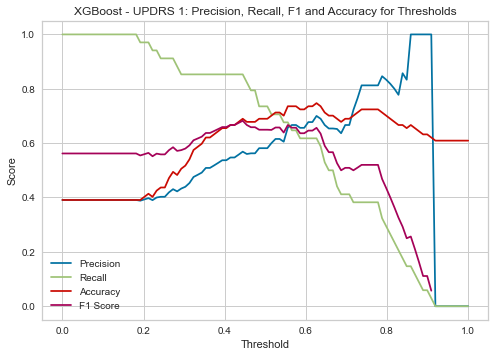

(0.6823529411764706, 0.4444444444444445)

In [284]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_1_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]

print("AUC:", roc_auc_score(y_test1, preds), 
      "\nAccuracy:", accuracy_score(y_test1, preds>0.4),
       "\nPrecision:", precision_score(y_test1, preds>0.4), 
       "\nRecall:", recall_score(y_test1, preds>0.4),
       "\nTheshold: 0.4")

plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'XGBoost')

AUC: 0.8596825396825396 
Accuracy: 0.6363636363636364 
Precision: 0.43636363636363634 
Recall: 0.96 
Theshold: 0.17


c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

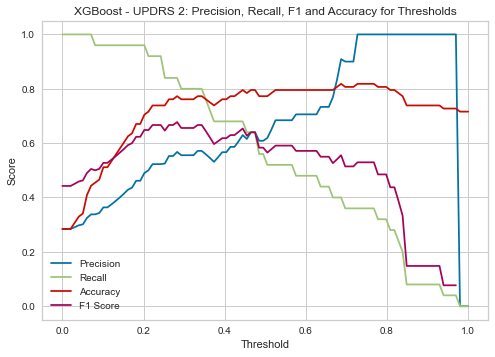

(0.6774193548387097, 0.2828282828282829)

In [285]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_2_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]

print("AUC:", roc_auc_score(y_test2, preds), 
      "\nAccuracy:", accuracy_score(y_test2, preds>0.17),
       "\nPrecision:", precision_score(y_test2, preds>0.17), 
       "\nRecall:", recall_score(y_test2, preds>0.17),
       "\nTheshold: 0.17")
plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'XGBoost')

AUC: 0.6432783018867925 
Accuracy: 0.38823529411764707 
Precision: 0.3780487804878049 
Recall: 0.96875 
Theshold: 0.15


c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to

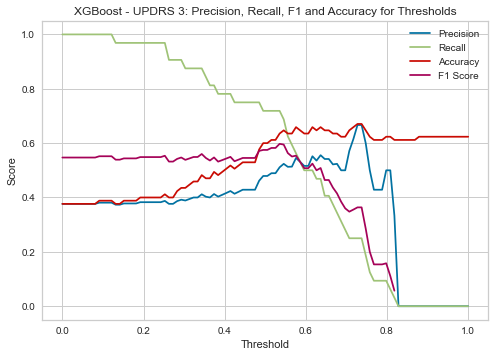

(0.5974025974025974, 0.5353535353535354)

In [286]:
# Load the saved model
model = joblib.load('../models/xgboost_updrs_3_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]

print("AUC:", roc_auc_score(y_test3, preds), 
      "\nAccuracy:", accuracy_score(y_test3, preds>0.15),
       "\nPrecision:", precision_score(y_test3, preds>0.15), 
       "\nRecall:", recall_score(y_test3, preds>0.15),
       "\nTheshold: 0.15")

plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'XGBoost')

## LGBoost Future Categorical Predictions

In [292]:
lgb_forecast_hyperparams_df.loc['tree_learner'] = lgb_forecast_hyperparams_df.loc['tree_learner'].map({0: 'serial', 1: 'feature', 2: 'data', 3: 'voting'})
lgb_forecast_hyperparams_df.loc['boosting'] = lgb_forecast_hyperparams_df.loc['boosting'].map({0: 'gbdt', 1: 'dart', 2: 'rf'})
lgb_forecast_hyperparams_df.loc['is_unbalance'] = lgb_forecast_hyperparams_df.loc['is_unbalance'].map({0: "true", 1: "false"})

# convert floats to ints
lgb_forecast_hyperparams_df.loc['max_depth'] = lgb_forecast_hyperparams_df.loc['max_depth'].astype(int)
lgb_forecast_hyperparams_df.loc['max_delta_step'] = lgb_forecast_hyperparams_df.loc['max_delta_step'].astype(int)
lgb_forecast_hyperparams_df.loc['min_data_in_leaf'] = lgb_forecast_hyperparams_df.loc['min_data_in_leaf'].astype(int)
lgb_forecast_hyperparams_df.loc['bagging_freq'] = lgb_forecast_hyperparams_df.loc['bagging_freq'].astype(int)

In [294]:
def prepare_future_lgboost_model(lgb_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning
    hp_opt = lgb_hyperparams_df[target].to_dict()
    # convert the categoricals parameter to correct names by mapping the values
    hp_opt['random_state'] = 42

    model = LGBMClassifier(**hp_opt)
    
    return model

In [295]:
def train_lgboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename =f'../models/lgboost_{updrs}_model_hyperopt_smote.sav'
    pickle.dump(model, open(filename, 'wb'))

    return model

In [296]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_future_lgboost_model(lgb_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_lgboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7368717905579903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7368717905579903
[LightGBM] [Warning] lambda_l1 is set=4.924832507056549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.924832507056549
[LightGBM] [Warning] lambda_l2 is set=7.728146819576027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.728146819576027
[LightGBM] [Warning] bagging_fraction is set=0.7662481474372647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662481474372647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.7368717905579903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7368717905579903
[LightGBM] [Warning] lambda_l1 is set=4.924832507056549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.924832507056549
[LightGBM] [Warning] lambda_l2 is set=7.728146819576027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.728146819576027
[LightGBM] [Warning] bagging_fraction is set=0.7662481474372647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662481474372647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

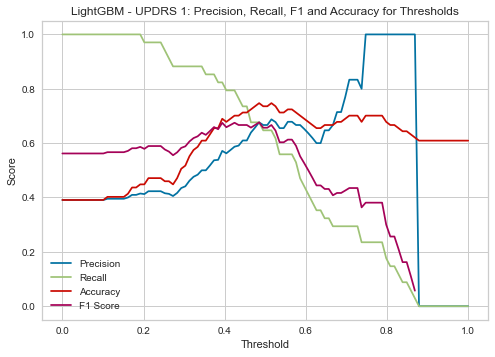

(0.6764705882352942, 0.48484848484848486)

In [299]:
# Load the saved model
model = joblib.load('../models/lgboost_updrs_1_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]

print("AUC:", roc_auc_score(y_test1, preds), 
      "\nAccuracy:", accuracy_score(y_test1, preds>0.4),
       "\nPrecision:", precision_score(y_test1, preds>0.4), 
       "\nRecall:", recall_score(y_test1, preds>0.4),
       "\nTheshold: 0.4")

plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'LightGBM')

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.820174975427512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.820174975427512
[LightGBM] [Warning] lambda_l1 is set=1.726209961845676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.726209961845676
[LightGBM] [Warning] lambda_l2 is set=9.968733070887914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.968733070887914
[LightGBM] [Warning] bagging_fraction is set=0.3069356024569016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3069356024569016
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

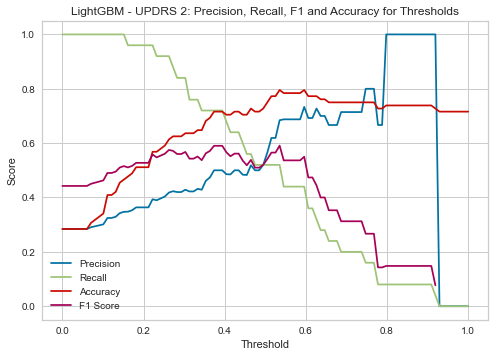

(0.5909090909090909, 0.5353535353535354)

In [302]:

# Load the saved model
model = joblib.load('../models/lgboost_updrs_2_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]

print("AUC:", roc_auc_score(y_test2, preds), 
      "\nAccuracy:", accuracy_score(y_test2, preds>0.38),
       "\nPrecision:", precision_score(y_test2, preds>0.38), 
       "\nRecall:", recall_score(y_test2, preds>0.38),
       "\nTheshold: 0.38")

plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'LightGBM')
    


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.696854884433846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.696854884433846
[LightGBM] [Warning] lambda_l1 is set=1.3357567971782522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3357567971782522
[LightGBM] [Warning] lambda_l2 is set=9.155461845313472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.155461845313472
[LightGBM] [Warning] bagging_fraction is set=0.8206721374654345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206721374654345
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\

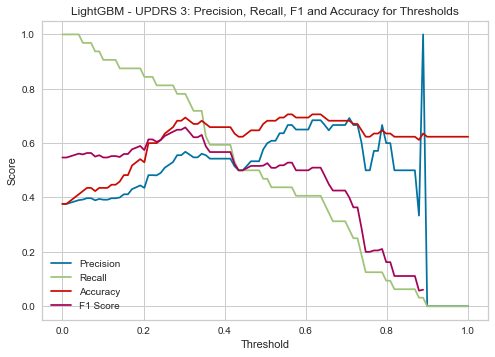

(0.6578947368421052, 0.30303030303030304)

In [305]:
# Load the saved model
model = joblib.load('../models/lgboost_updrs_3_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]

print("AUC:", roc_auc_score(y_test3, preds), 
      "\nAccuracy:", accuracy_score(y_test3, preds>0.3),
       "\nPrecision:", precision_score(y_test3, preds>0.3), 
       "\nRecall:", recall_score(y_test3, preds>0.3),
       "\nTheshold: 0.3")

plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'LightGBM')

## Compare Catboost Model

In [315]:
def prepare_future_catboost_model(cboost_hyperparams_df, target):
    # train the model using the hyperparameters from the hyperparameter tuning  
    updrs_hp = cboost_hyperparams_df[target].to_dict()
    updrs_hp['depth'] = int(updrs_hp['depth'])
    
    
    updrs_hp['random_state'] = 42
    
    model = CatBoostClassifier(**updrs_hp)
    
    return model

In [316]:
def train_catboost(train_df, test_df, updrs, model):
    features = train_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    target = train_df[f'{updrs}_cat']
    X_test = test_df.drop([f'{updrs}_cat', 'kfold'], axis=1)
    y_test = test_df[f'{updrs}_cat']


    model.fit(features, target)
    
    # Make predictions on the test data
    predictions = model.predict_proba(X_test)[:, 1]

    # Evaluate AUC on the test data
    auc = roc_auc_score(y_test, predictions)
    print("AUC on Test Data:", auc)


    # Save the trained model to a file
    filename = f'../models/catboost_{updrs}_model_hyperopt_smote.sav'
    joblib.dump(model, filename)

    return model

In [317]:
# cboost_forecast_hyperparams_df.loc['depth', 'updrs_1'] = 1
# cboost_forecast_hyperparams_df.loc['depth', 'updrs_2'] = 2
# cboost_forecast_hyperparams_df.loc['depth', 'updrs_3'] = 2
cboost_forecast_hyperparams_df

,updrs_1,updrs_2,updrs_3
bagging_temperature,4.429427,4.095758,1.162359
depth,7.000000,6.000000,4.000000
l2_leaf_reg,5.641367,5.757078,7.356710
learning_rate,0.366781,0.954836,0.973876
min_data_in_leaf,8.000000,8.000000,4.000000


In [318]:
for updrs, df, test_df in zip(['updrs_1', 'updrs_2', 'updrs_3'], 
                     [updrs1_yr_df_smote, updrs2_yr_df_smote, updrs3_yr_df_smote],
                     [updrs1_yr_test, updrs2_yr_test, updrs3_yr_test]):
    model = prepare_future_catboost_model(cboost_forecast_hyperparams_df, updrs)
    train_df = df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    test_df = test_df.drop(columns=['visit_id', 'patient_id', f'{updrs}'])
    y_test = test_df[f'{updrs}_cat']
    y_train = train_df[f'{updrs}_cat']
    
    best_model = train_catboost(train_df, test_df, updrs, model)
    # compare the results of the model
    X_test = test_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    test_preds = best_model.predict_proba(X_test)[:, 1]

    test_auc = roc_auc_score(y_test, test_preds)
    X_train = train_df.drop(columns=[f'{updrs}_cat', 'kfold'])
    train_preds = best_model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_preds)
    print(f'{updrs} Results: \nTest AUC = {test_auc} \nTrain AUC = {train_auc}\n')

0:	learn: 0.6115203	total: 1.14s	remaining: 18m 58s
1:	learn: 0.5230733	total: 2.22s	remaining: 18m 29s
2:	learn: 0.4711494	total: 3.22s	remaining: 17m 50s
3:	learn: 0.4273520	total: 3.89s	remaining: 16m 7s
4:	learn: 0.3847608	total: 4.51s	remaining: 14m 58s
5:	learn: 0.3335119	total: 5.11s	remaining: 14m 7s
6:	learn: 0.2985969	total: 5.7s	remaining: 13m 28s
7:	learn: 0.2662901	total: 6.29s	remaining: 13m
8:	learn: 0.2368830	total: 6.92s	remaining: 12m 41s
9:	learn: 0.2179247	total: 7.52s	remaining: 12m 24s
10:	learn: 0.1995563	total: 8.12s	remaining: 12m 10s
11:	learn: 0.1830940	total: 8.78s	remaining: 12m 3s
12:	learn: 0.1618647	total: 9.75s	remaining: 12m 20s
13:	learn: 0.1514815	total: 10.5s	remaining: 12m 22s
14:	learn: 0.1419649	total: 11.3s	remaining: 12m 24s
15:	learn: 0.1270868	total: 12.1s	remaining: 12m 25s
16:	learn: 0.1143033	total: 12.8s	remaining: 12m 17s
17:	learn: 0.1060066	total: 13.3s	remaining: 12m 8s
18:	learn: 0.0975563	total: 14s	remaining: 12m 2s
19:	learn: 0.08

AUC: 0.7935627081021088 
Accuracy: 0.7126436781609196 
Precision: 0.6046511627906976 
Recall: 0.7647058823529411 
Theshold: 0.22


c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


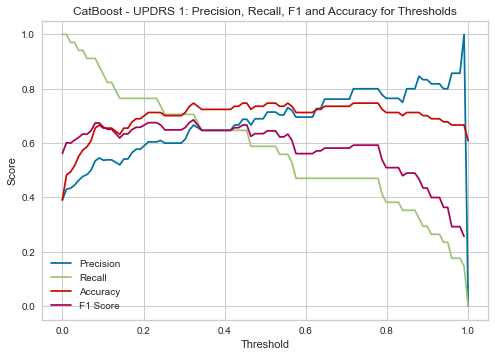

(0.6857142857142857, 0.32323232323232326)

In [323]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_1_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test1 = updrs1_yr_test.drop(columns=['updrs_1_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_1'])
y_test1 = updrs1_yr_test['updrs_1_cat']

preds = model.predict_proba(X_test1)[:, 1]

print("AUC:", roc_auc_score(y_test1, preds), 
      "\nAccuracy:", accuracy_score(y_test1, preds>0.22),
       "\nPrecision:", precision_score(y_test1, preds>0.22), 
       "\nRecall:", recall_score(y_test1, preds>0.22),
       "\nTheshold: 0.22")

plot_precision_recall_accuracy(y_test1, preds, 'UPDRS 1', 'CatBoost')

AUC: 0.7580952380952382 
Accuracy: 0.6931818181818182 
Precision: 0.47368421052631576 
Recall: 0.72 
Theshold: 0.1


c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


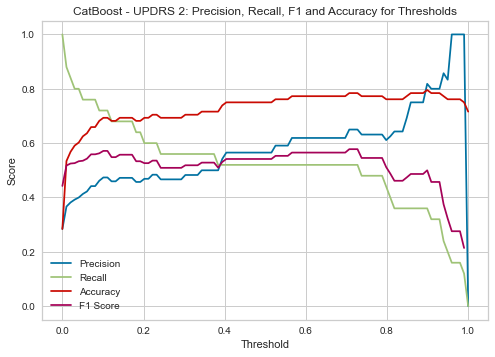

(0.5777777777777778, 0.7070707070707072)

In [324]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_2_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test2 = updrs2_yr_test.drop(columns=['updrs_2_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_2'])
y_test2 = updrs2_yr_test['updrs_2_cat']

preds = model.predict_proba(X_test2)[:, 1]

print("AUC:", roc_auc_score(y_test2, preds), 
      "\nAccuracy:", accuracy_score(y_test2, preds>0.1),
       "\nPrecision:", precision_score(y_test2, preds>0.1), 
       "\nRecall:", recall_score(y_test2, preds>0.1),
       "\nTheshold: 0.1")

plot_precision_recall_accuracy(y_test2, preds, 'UPDRS 2', 'CatBoost')

AUC: 0.7093160377358492 
Accuracy: 0.6588235294117647 
Precision: 0.5348837209302325 
Recall: 0.71875 
Theshold: 0.15


c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


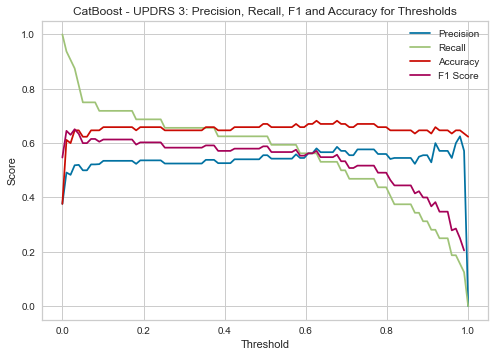

(0.6511627906976744, 0.030303030303030304)

In [325]:
# Load the saved model
model = joblib.load('../models/catboost_updrs_3_model_hyperopt_smote.sav')

# Make predictions on the test data
X_test3 = updrs3_yr_test.drop(columns=['updrs_3_cat', 'kfold', 'visit_id', 'patient_id', 'updrs_3'])
y_test3 = updrs3_yr_test['updrs_3_cat']

preds = model.predict_proba(X_test3)[:, 1]

print("AUC:", roc_auc_score(y_test3, preds), 
      "\nAccuracy:", accuracy_score(y_test3, preds>0.15),
       "\nPrecision:", precision_score(y_test3, preds>0.15), 
       "\nRecall:", recall_score(y_test3, preds>0.15),
       "\nTheshold: 0.15")

plot_precision_recall_accuracy(y_test3, preds, 'UPDRS 3', 'CatBoost')

In [322]:
# compare the results of the model
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_preds)
train_preds = best_model.predict(X_train)
train_auc = roc_auc_score(y_train, train_preds)
test_auc, train_auc

(0.6615566037735849, 1.0)

## Compare to Logistic Regression Model

In [85]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_results = cross_fold_validation(updrs1_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_results = cross_fold_validation(updrs2_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_results = cross_fold_validation(updrs3_df, model, 'updrs_3')

c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\Dagart\anaconda3\envs\easypy37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [86]:
updrs1_results

(0.511721383287093,
 0.780847703040674,
 0.32282051282051283,
 0.062211088895139766)

In [87]:
updrs2_results

(0.5258909849605227,
 0.8464349962704578,
 0.42333333333333323,
 0.07048988874546684)

In [88]:
updrs3_results

(0.5240749211448716,
 0.8194894035589735,
 0.3485714285714286,
 0.07900396151669495)

## Forecast with Logistic Regression

In [326]:
model = LogisticRegression()

# run cross fold validation on the updrs 1 data
updrs1_forecast_results = cross_fold_validation(updrs1_yr_df, model, 'updrs_1')

model = LogisticRegression()
updrs2_forecast_results = cross_fold_validation(updrs2_yr_df, model, 'updrs_2')

model = LogisticRegression()
updrs3_forecast_results = cross_fold_validation(updrs3_yr_df, model, 'updrs_3')

c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\Users\dagar\Envs\titanic_ds_py37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

In [327]:
updrs1_forecast_results

(0.5613409717955513,
 0.5909166173861621,
 0.4797811059907834,
 0.4192382230172928)

In [328]:
updrs2_forecast_results

(0.5781698305559398,
 0.6749032217782218,
 0.47944498312145367,
 0.3166643139469227)

In [329]:
updrs3_forecast_results

(0.5740388677518793, 0.6128256912049153, 0.4997810538607502, 0.395449887271982)